AttributeError: 'AxesSubplot' object has no attribute 'set_axis'

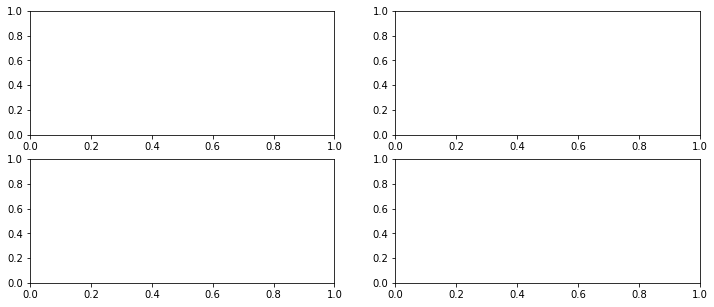

In [1]:
import numpy as np
import scipy
import scipy.sparse
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

import sys
from IPython.display import display, clear_output
class Model:
    def __init__(self):
        self.th0 = 0
        self.gamma = 0.5
        self.N = 100000
        self.P = 16
        self.f = 0.01
        self.kappa = 11
        self.xi0 = 1
        self.dt = 1e-2
        self.T = 10
        self.phi = 0
        self.tau = 1e-1

    def makePatterns(self):
        self.eta = scipy.sparse.random(self.N, self.P, density=self.f,
                                       data_rvs=lambda n: np.ones((n,)))

    def gain(self, x):
        x1 = np.where((self.th0 + x) <= 0., 0, self.th0 + x)
        return np.power(x1, self.gamma)

    def Jr(self, c):
        r = self.gain(c)
        pc = self.eta.T.dot(r) - self.f * r.sum()
        return (self.eta.dot(
            pc) - self.f * pc.sum() - r * self.phi) * self.kappa / self.N

    def grad(self, c):
        return (-c + self.Jr(c) + np.random.randn(c.shape[0], c.shape[
            1]) * self.xi0) / self.tau

np.random.seed(12354)
mod = Model()
mod.N = 10000
mod.P = 16
mod.f = 0.1
# mod.eta*=0
mod.xi0 = 0.5
mod.kappa = 1000

phiAmp = 400
phi0 = phiAmp + 600
nT = 50000
memRec = np.zeros((nT,))
tRecAll = []
ITR = np.empty((0, 1))
itrByLen = [np.empty((k - 1, 0)) for k in range(1, mod.P + 1)]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,
                                             figsize=(12, 5))
ax4.set_axis('off')
display(fig)

for it in tqdm_notebook(range(1000)):
    print(str(it) + "        \r")
    mod.makePatterns()
    tr = np.empty((mod.N, nT))
    # c = np.random.randn(mod.N, 1)
    c = (mod.eta.tocsr()[:, 0]).todense()
    tr[:, :1] = c
    for k in tqdm_notebook(range(1, tr.shape[1])):
        c += mod.grad(c) * mod.dt
        tr[:, k] = np.array(c)[:, 0]
        mod.phi = phi0 - phiAmp * np.sin(k / 50)
    mu = (mod.eta.T.dot(mod.gain(tr)) - mod.f * mod.gain(tr).sum(
        axis=0)).T / mod.N
    mem1 = ((mu > 0.5).cumsum(axis=0) > 0).sum(axis=1)
    trec = np.argwhere(np.diff(mem1))
    tRecAll.append(trec)
    ITR = np.vstack((ITR, np.diff(trec, axis=0)))
    memRec += mem1
    itrByLen[len(trec) - 1] = np.hstack(
        (itrByLen[len(trec) - 1], np.diff(trec, axis=0)))
    ax1.cla()
    ax1.plot(memRec / len(tRecAll))
    ax2.cla()
    ax2.hist(ITR, bins=100)
    ax2.set_xlim([0, 10000])
    ax2.set_yscale('log')
    ax3.cla()
    for itr in itrByLen:
        if itr.size > 0:
            ax3.plot(itr.mean(axis=1))
    clear_output(wait=True)
    display(fig)
    fig.savefig('res.png', dpi=600)
